In [183]:

import numpy as np
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
from optimal_interpolation import OImerge
import calendar
from auxiliary_merge import *


########################################################################################################################

# basic settings
# y1 = int(sys.argv[3])
# y2 = int(sys.argv[4])
# year = [y1, y2]
year = [1980, 1980]
weightmode = 'RMSE'
vars = ['prcp', 'tmean', 'trange']

# "Gaussian": prcp will be transformed into normal distributions; "Actual": actual space
# "Gaussian" is not a good choice because station prcp regression using box-cox has large underestimation
prcp_space = 'Actual'

hwsize = 2  # 5X5 space window used to support estimation at the center grid
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)

# output path of OImerged data
path_oimerge = '/Users/localuser/GMET/merge'
# path_oimerge = '/home/gut428/OImerge'

# path of merged reanalysis data
path_bac = '/Users/localuser/GMET/merge'
path_bac_stn = '/Users/localuser/Research/Test'
# path_bac = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/Reanalysis_merge'
# path_bac_stn = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/CrossValidate_2layer'
file_corrmerge_stn = [''] * len(vars)
for i in range(len(vars)):
    file_corrmerge_stn[i] = path_bac_stn + '/mergecorr_' + vars[i] + '_' + weightmode + '.npz'

# path of regressed observations
# path_obs = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout'
path_obs = '/Users/localuser/GMET/merge'

# the near stations of each station
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
near_file_GMET = '/Users/localuser/GMET/pyGMET_NA/weight_nearstn.npz'

# mask file
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
file_mask = './DEM/NA_DEM_010deg_trim.mat'

########################################################################################################################

# basic processing
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
nrows, ncols = np.shape(mask)

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

In [261]:
v=0
y=1980
m=7

In [262]:
    print('OI merge at stations:', vars[v])
    filemerge_stn = path_oimerge + '/OImerge_stn_' + vars[v] + '.npz'
#     if os.path.isfile(filemerge_stn):
#         continue

    # load corrected/merged reanalysis data at all station points (those are totally independent with station observations)
    datatemp = np.load(file_corrmerge_stn[v])
    reamerge_stn_all = datatemp['reamerge_stn']
    reacorr_stn_all = datatemp['reacorr_stn']
    reanum, nstn, ntimes = np.shape(reacorr_stn_all)
    del datatemp

    # load near station information
    datatemp = np.load(near_file_GMET)
    if vars[v] == 'prcp':
        near_loc = datatemp['near_stn_prcpLoc']
        near_weight = datatemp['near_stn_prcpWeight']
    else:
        near_loc = datatemp['near_stn_tempLoc']
        near_weight = datatemp['near_stn_tempWeight']
    del datatemp

    oimerge_stn = np.zeros([nstn, ntimes])

OI merge at stations: prcp


In [263]:
            print('merging error: date:', y * 100 + m + 1)
            indym = (date_number['yyyy'] == y) & (date_number['mm'] == m + 1)
            nday = sum(indym)
            oimerge_stnym = np.zeros([nstn, nday])

            # load station regression estimates at all stations (locally weighted regression)
            date_cal_start = y * 10000 + (m + 1) * 100 + 1
            date_cal_end = y * 10000 + (m + 1) * 100 + calendar.monthrange(y, m + 1)[1]
            datestr = str(date_cal_start) + '-' + str(date_cal_end)
            file1 = path_obs + '/stndata_' + datestr + '.npz'
            file2 = path_obs + '/error_' + datestr + '.npz'
            datatemp1 = np.load(file1)
            datatemp2 = np.load(file2)
            observation_stn = datatemp1[vars[v] + '_stn_daily']
            if vars[v] == 'prcp':
                regression_stn = observation_stn + datatemp2['pcp' + '_err_stn_raw']
            else:
                regression_stn = observation_stn + datatemp2[vars[v] + '_err_stn']
            del datatemp1, datatemp2

merging error: date: 198008


In [264]:
            # get the best reanalysis among three original reanalysis datasets and one merged dataset for each station
            reamerge_stn = reamerge_stn_all[:, indym]
            reacorr_stn = reacorr_stn_all[:, :, indym]
            rearmse = np.zeros([nstn, reanum+1])
            rearmse[:, 0] = calmetric(reamerge_stn, observation_stn, metname='RMSE')
            for i in range(3):
                rearmse[:, i + 1] = calmetric(reacorr_stn[i, :, :], observation_stn, metname='RMSE')
            bestchoice = np.argmin(rearmse, axis=1)
            reafinal_stn = reamerge_stn.copy()
            for i in range(nstn):
                if bestchoice[i] > 0:
                    reafinal_stn[i, :] = reacorr_stn[bestchoice[i] - 1, i, :]


In [266]:
            # use optimal interpolation to get OI-merged estimate at each station points
            for i in range(nstn):
                if np.mod(i,1000)==0:
                    print(i)
                if not np.isnan(observation_stn[i, 0]):
                    near_loci = near_loc[i, :]
                    near_loci = near_loci[near_loci > -1]
                    if len(near_loci) > (hwsize * 2 + 1) ** 2:
                        near_loci = near_loci[0:(hwsize * 2 + 1) ** 2]
                    if len(near_loci) > 6:
                        near_loci = near_loci[0:6]
                    b_tar = reafinal_stn[i, :]
                    o_tar = regression_stn[i, :]
                    b_near = reafinal_stn[near_loci, :]
                    o_near = regression_stn[near_loci, :]

                    tar_err_b = b_tar - observation_stn[i, :]
                    near_err_b = b_near - observation_stn[near_loci, :]
                    near_err_o = o_near - observation_stn[near_loci, :]
                    try:
                        weight = OImerge(tar_err_b, near_err_b, near_err_o)
                    except:
                        weight=np.nan
                    if np.any(np.isnan(weight)) or np.any(abs(weight) > 2):
                        weight = near_weight[i, 0:len(near_loci)]
                        weight = weight / np.sum(weight)

                    diff = o_near - b_near
                    merge_est = b_tar.copy()
                    for id in range(nday):
                        merge_est[id] = merge_est[id] + np.dot(weight, diff[:, id])

                    oimerge_stnym[i, :] = merge_est
#                     oimerge_stnym[i, :] = b_tar*0.5+o_tar*0.5

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [268]:
met = np.zeros([3,nstn,4])
for i in range(nstn):
    met[0,i,:] = au.metric(observation_stn[i,:],oimerge_stnym[i,:])
    met[1,i,:] = au.metric(observation_stn[i,:],regression_stn[i,:])
    met[2,i,:] = au.metric(observation_stn[i,:],reafinal_stn[i,:])
for i in range(3):
    print(np.nanmedian(met[i,:,:],axis=0))

[ 0.80824242 -0.02587807  1.481109    2.96656447]
[0.76218455 0.07026028 1.64453083 3.39052361]
[ 0.77594443 -0.05217692  1.53164707  3.17570477]


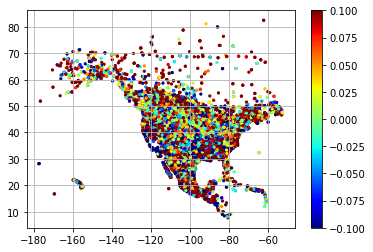

In [270]:
diff = met[0,:,0] - met[1,:,0]
plt.scatter(stninfo[:,2],stninfo[:,1],5,diff,cmap='jet')
plt.colorbar()
plt.clim([-0.1,0.1])
plt.grid()

In [236]:
induse=(stninfo[:,2]>-180) & (stninfo[:,1]>60)
for i in range(3):
    print(np.nanmean(met[i,induse,:],axis=0))

[0.6761352  0.03298606 0.86428927 1.9940687 ]
[0.63742659 0.02651124 0.90516463 2.03880107]
[0.69420588 0.01879073 0.82154881 1.87687602]


In [245]:
file='/Users/localuser/Downloads/'

1